Binary 3/6 C)

mRNA localization using binary classification (cytoplasm/nucleus) (part 1/2): basic model with: <br> 
<br>
a) Method 6: no feature selection and class weights accounted for <br>
b) Method 7: with feature importance-based feature selection (SHAP) (method/model #3)  and class weights accounted for<br>

In [1]:
import pandas as pd
from catboost import CatBoostClassifier
from catboost import Pool
import matplotlib.pyplot as plt
import numpy as np
import shap

In [2]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, average_precision_score, roc_auc_score, precision_recall_curve, roc_curve, auc, f1_score, classification_report

In [3]:
#data initialization

#Cytoplasm (label = 0)
CP_train = pd.read_csv("../../Data/InputData/CP_iLearnfeatvalues_train_CSV.csv")
CP_test = pd.read_csv("../../Data/InputData/CP_iLearnfeatvalues_test_CSV.csv")

#Nucleus (label = 3)
NU_train = pd.read_csv("../../Data/InputData/NU_iLearnfeatvalues_train_CSV.csv")
NU_test = pd.read_csv("../../Data/InputData/NU_iLearnfeatvalues_test_CSV.csv")

print("CP TRAIN, TEST SHAPE:", CP_train.shape, ",", CP_test.shape)
print("NU TRAIN, TEST SHAPE:", NU_train.shape, ",", NU_test.shape)

CP TRAIN, TEST SHAPE: (824, 1026) , (206, 1026)
NU TRAIN, TEST SHAPE: (640, 1026) , (160, 1026)


In [4]:
###### NEXT STEP #######
#Merge training files for binary classification (CP+ER, CP+MT, CP+NU, ER+MT, ER+NU, MT+NU)
#Merge testing files same way

#How to merge: 
# - https://saturncloud.io/blog/how-to-merge-two-csv-files-into-one-with-pandas-by-id/
# or pd.concat


In [5]:


#Group 3: CP + NU

frames_CN_tra =[CP_train, NU_train]
frames_CN_tes = [CP_test, NU_test]

CP_NU_train = pd.concat(frames_CN_tra)
CP_NU_test = pd.concat(frames_CN_tes)



In [6]:
print("CP + NU TRAIN, TEST SHAPE:", CP_NU_train.shape, ",", CP_NU_test.shape)


CP + NU TRAIN, TEST SHAPE: (1464, 1026) , (366, 1026)


In [7]:
CP_NU_test.head(209)

,#,label,AAAAA,AAAAC,AAAAG,AAAAT,AAACA,AAACC,AAACG,AAACT,...,TTTCG,TTTCT,TTTGA,TTTGC,TTTGG,TTTGT,TTTTA,TTTTC,TTTTG,TTTTT
0,mRNALoc_16986#79230|0|testing,0,0.008836,0.002834,0.002334,0.003168,0.001667,0.003168,0.000000,0.002001,...,0.000834,0.001834,0.001167,0.000500,0.001667,0.001834,0.001667,0.002501,0.002001,0.011504
1,mRNALoc_8139#3082|0|testing,0,0.009503,0.002501,0.003168,0.006002,0.003001,0.000834,0.000167,0.002668,...,0.000167,0.003168,0.001667,0.001334,0.001667,0.003501,0.005835,0.001667,0.003501,0.005669
2,mRNALoc_19034#8816|0|testing,0,0.006005,0.001168,0.002168,0.001168,0.001668,0.001334,0.000167,0.000334,...,0.000167,0.001168,0.000834,0.001501,0.000667,0.001668,0.002502,0.001001,0.001334,0.002002
3,mRNALoc_19863#9737|0|testing,0,0.005673,0.001335,0.002503,0.002837,0.001502,0.001335,0.000167,0.001001,...,0.000000,0.001168,0.002002,0.001001,0.002670,0.001001,0.001168,0.000834,0.001669,0.001502
4,mRNALoc_19031#8816|0|testing,0,0.006008,0.001168,0.002170,0.001168,0.001669,0.001335,0.000167,0.000334,...,0.000167,0.001168,0.000834,0.001502,0.000668,0.001669,0.002503,0.001001,0.001335,0.002003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204,mRNALoc_8179#30957|0|testing,0,0.000732,0.000183,0.000366,0.000732,0.000549,0.000366,0.000183,0.000732,...,0.000000,0.000183,0.000366,0.000732,0.000732,0.000549,0.000183,0.000183,0.000549,0.000000
205,mRNALoc_19660#94229|0|testing,0,0.006595,0.001465,0.002748,0.002565,0.002015,0.000550,0.000183,0.001099,...,0.000183,0.002381,0.003114,0.001649,0.001465,0.001832,0.002931,0.002565,0.003297,0.004396
0,mRNALoc_4836#21374|3|testing,3,0.001632,0.002176,0.001632,0.002176,0.001632,0.001088,0.000544,0.001088,...,0.000000,0.004353,0.000544,0.000544,0.001632,0.002176,0.003264,0.002720,0.002720,0.004897
1,mRNALoc_7063#26002|3|testing,3,0.002176,0.001088,0.003264,0.000544,0.001088,0.000544,0.000000,0.001088,...,0.000544,0.001632,0.001088,0.002176,0.001088,0.000000,0.001088,0.001088,0.001088,0.000544


In [8]:
#FOR CP+NU
noname_CN_train = CP_NU_train.drop("#", axis="columns")
noname_CN_test = CP_NU_test.drop("#", axis="columns")


CP_NU_X_train = noname_CN_train.drop("label", axis="columns")
CP_NU_y_train = noname_CN_train["label"]

CP_NU_X_test = noname_CN_test.drop("label", axis="columns")
CP_NU_y_test = noname_CN_test["label"]

print("CP + NU X train:", CP_NU_X_train.shape)
print("CP + NU y train:", CP_NU_y_train.shape)
print("CP + NU X test:", CP_NU_X_test.shape)
print("CP + NU y test:", CP_NU_y_test.shape)

CP + NU X train: (1464, 1024)
CP + NU y train: (1464,)
CP + NU X test: (366, 1024)
CP + NU y test: (366,)


In [9]:
# Create data pools for feature importance/selection for CP + NU

CN_feature_names = list(CP_NU_X_train.columns)
print("Number of features:", len(CN_feature_names))

CN_train_pool = Pool(CP_NU_X_train, CP_NU_y_train, feature_names=CN_feature_names)

CN_test_pool = Pool(CP_NU_X_test, CP_NU_y_test)

print("*Cytoplasm, Nucleus Pools created")

Number of features: 1024
*Cytoplasm, Nucleus Pools created


    Method 6: Basic model with class imbalance taken into account (but without feature importance/selection/hyperparameter tuning)

In [10]:
CN_binary_model = CatBoostClassifier(loss_function="MultiClass", auto_class_weights="Balanced")

In [11]:
#Fit model to CN data

CN_binary_model.fit(CN_train_pool)

Learning rate set to 0.08068
0:	learn: 0.6796359	total: 388ms	remaining: 6m 28s
1:	learn: 0.6676103	total: 513ms	remaining: 4m 15s
2:	learn: 0.6558958	total: 642ms	remaining: 3m 33s
3:	learn: 0.6442329	total: 759ms	remaining: 3m 9s
4:	learn: 0.6323072	total: 876ms	remaining: 2m 54s
5:	learn: 0.6222614	total: 999ms	remaining: 2m 45s
6:	learn: 0.6143704	total: 1.11s	remaining: 2m 38s
7:	learn: 0.6055776	total: 1.23s	remaining: 2m 33s
8:	learn: 0.5984738	total: 1.36s	remaining: 2m 29s
9:	learn: 0.5903071	total: 1.5s	remaining: 2m 28s
10:	learn: 0.5834163	total: 1.72s	remaining: 2m 34s
11:	learn: 0.5767742	total: 1.89s	remaining: 2m 35s
12:	learn: 0.5693102	total: 2.02s	remaining: 2m 33s
13:	learn: 0.5632809	total: 2.15s	remaining: 2m 31s
14:	learn: 0.5552748	total: 2.33s	remaining: 2m 32s
15:	learn: 0.5495812	total: 2.45s	remaining: 2m 30s
16:	learn: 0.5431518	total: 2.58s	remaining: 2m 29s
17:	learn: 0.5367489	total: 2.7s	remaining: 2m 27s
18:	learn: 0.5299415	total: 2.82s	remaining: 2m 

In [12]:
#Check parameters used in this model fit

CN_bin_params = CN_binary_model.get_all_params()
print("Basic model parameters:", CN_bin_params)

Basic model parameters: {'nan_mode': 'Min', 'eval_metric': 'MultiClass', 'iterations': 1000, 'sampling_frequency': 'PerTree', 'leaf_estimation_method': 'Newton', 'grow_policy': 'SymmetricTree', 'penalties_coefficient': 1, 'boosting_type': 'Plain', 'model_shrink_mode': 'Constant', 'feature_border_type': 'GreedyLogSum', 'bayesian_matrix_reg': 0.10000000149011612, 'eval_fraction': 0, 'force_unit_auto_pair_weights': False, 'l2_leaf_reg': 3, 'random_strength': 1, 'rsm': 1, 'boost_from_average': False, 'model_size_reg': 0.5, 'pool_metainfo_options': {'tags': {}}, 'use_best_model': False, 'class_names': [0, 3], 'random_seed': 0, 'depth': 6, 'posterior_sampling': False, 'border_count': 254, 'class_weights': [1, 1.287500023841858], 'bagging_temperature': 1, 'classes_count': 0, 'auto_class_weights': 'Balanced', 'sparse_features_conflict_fraction': 0, 'leaf_estimation_backtracking': 'AnyImprovement', 'best_model_min_trees': 1, 'model_shrink_rate': 0, 'min_data_in_leaf': 1, 'loss_function': 'Multi

In [13]:
#Prediction using X_test
CN_y_pred = CN_binary_model.predict(CP_NU_X_test)

#Predication probability

CN_y_prob = CN_binary_model.predict_proba(CP_NU_X_test)

In [15]:
# Calculate F1 score and get classification report

print("Model 6: Basic model w/ class imbalance accounted for - Cytoplasm & nucleus")

CN_cr = classification_report(CP_NU_y_test, CN_y_pred, digits=4)
print(CN_cr)

print('Accuracy score: ', accuracy_score(CP_NU_y_test, CN_y_pred))


CN_f1 = f1_score(CP_NU_y_test, CN_y_pred, average='macro')
print(f"\nF1 Score: {CN_f1}")
# print('Roc auc score : ', roc_auc_score(CP_NU_y_test, CN_y_prob))

Model 6: Basic model w/ class imbalance accounted for - Cytoplasm & nucleus
              precision    recall  f1-score   support

           0     0.6154    0.7379    0.6711       206
           3     0.5462    0.4062    0.4659       160

    accuracy                         0.5929       366
   macro avg     0.5808    0.5721    0.5685       366
weighted avg     0.5851    0.5929    0.5814       366

Accuracy score:  0.592896174863388

F1 Score: 0.5685157492463624


In [16]:
# Confusion matrix for selected data

print("real values shape:", CP_NU_y_test.shape)
print("prediction shape:", CN_y_pred.shape)

CN_y_pred_fl = CN_y_pred
print("flattened prediction values shape:", CN_y_pred_fl.ravel().shape, "\n")

CN_cMatrix = confusion_matrix(CP_NU_y_test, CN_y_pred_fl)
print(CN_cMatrix)

real values shape: (366,)
prediction shape: (366, 1)
flattened prediction values shape: (366,) 

[[152  54]
 [ 95  65]]


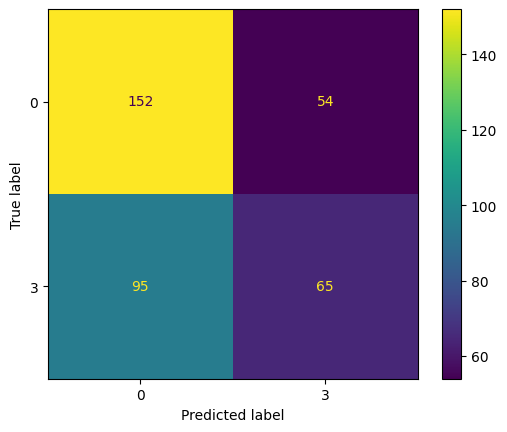

In [17]:
# Show image of confusion matrix

disp = ConfusionMatrixDisplay(confusion_matrix=CN_cMatrix, display_labels=CN_binary_model.classes_)
disp.plot()
plt.show()

    Method 2: Feature importance-based feature selection

In [28]:
#Feature importances for CN pair

CN_feat_importances = CN_binary_model.get_feature_importance(prettified=True)
CN_feat_importances.head(100)

,Feature Id,Importances
0,GGGGC,1.609391
1,TGCCC,1.097823
2,AAAAA,1.054853
3,AAGGG,0.866757
4,ACGTC,0.844651
...,...,...
95,CCAAT,0.233997
96,ATGCG,0.232107
97,GGCGA,0.228276
98,ACACG,0.227775


In [29]:
# Show only feature importances above 0.1

threshold_chosen_features = CN_feat_importances[CN_feat_importances['Importances'] >= 0.1]
num_chosen_features = len(threshold_chosen_features)

print(threshold_chosen_features)

print("\nAmount of features with importnace above 0.1 (selected features):", num_chosen_features)

    Feature Id  Importances
0        GGGGC     1.609391
1        TGCCC     1.097823
2        AAAAA     1.054853
3        AAGGG     0.866757
4        ACGTC     0.844651
..         ...          ...
309      GCAGG     0.102458
310      TTAAA     0.102113
311      GATAC     0.100762
312      CCAAC     0.100593
313      ACATT     0.100140

[314 rows x 2 columns]

Amount of features with importnace above 0.1 (selected features): 314


In [30]:
print("Sum of total feature importances: ", sum(CN_feat_importances.Importances))
print("Sum of feature importances >=0.1: ", sum(threshold_chosen_features.Importances))

Sum of total feature importances:  100.00000000000013
Sum of feature importances >=0.1:  72.35842498365047


In [31]:
# Select features with importance values above 0.1

CN_selected_feat = CN_feat_importances[:num_chosen_features]['Feature Id'].tolist()

print(CN_selected_feat)

['GGGGC', 'TGCCC', 'AAAAA', 'AAGGG', 'ACGTC', 'ATTCG', 'GAAGA', 'CTAGC', 'GCAGT', 'GGTCG', 'TACTG', 'CCTCT', 'TGACG', 'GGCAA', 'AATAT', 'GTAGC', 'AATCC', 'ATTTC', 'GCTCT', 'GGTGA', 'GCCCC', 'GGGGA', 'TGAAT', 'CTCTA', 'CATCT', 'TCAAT', 'CTAGT', 'CCGGC', 'CAGAT', 'ATCAC', 'TAGGG', 'CGTTG', 'AGGGG', 'GAAGT', 'TAAGG', 'AGAAG', 'CCCAA', 'CACTC', 'GGGAT', 'TAGAC', 'GACAG', 'CCTGC', 'CGGTA', 'TTCAA', 'TTGCT', 'GTACG', 'TGAAG', 'CAATT', 'CCCCA', 'GGATC', 'CCTAT', 'TCCCT', 'GCCGT', 'TTGTC', 'CCAGT', 'GTAGA', 'AACGA', 'CGAAA', 'ACCCT', 'GACGA', 'ACCGA', 'GTTAG', 'GTTAC', 'TGTAC', 'TGCTC', 'CGAGT', 'TGTCG', 'CCCTC', 'GTTTG', 'ACGCA', 'CTTAC', 'GCACA', 'ATCCT', 'TTCGA', 'ATCTC', 'CTAAG', 'GTACC', 'TCCTC', 'CTGGG', 'GTCTG', 'GGCAG', 'CTCGA', 'TGGGG', 'CCTGG', 'GATAG', 'AGTTC', 'AGGAA', 'CAGAC', 'AGTTG', 'TGAAC', 'GGCGT', 'CTCGC', 'TCGTA', 'TCCGT', 'CGTCC', 'CCAAT', 'ATGCG', 'GGCGA', 'ACACG', 'GCTAG', 'TACTT', 'GAGTT', 'TAGCC', 'GGTAT', 'AAGTT', 'AGTCC', 'AGCTA', 'CTTGT', 'ATGCC', 'TGGCT', 'AAATA', 

In [32]:
CP_NU_X_train.shape

(1464, 1024)

In [33]:
# See original training set

CP_NU_X_train.head(826)


,AAAAA,AAAAC,AAAAG,AAAAT,AAACA,AAACC,AAACG,AAACT,AAAGA,AAAGC,...,TTTCG,TTTCT,TTTGA,TTTGC,TTTGG,TTTGT,TTTTA,TTTTC,TTTTG,TTTTT
0,0.003643,0.000792,0.001426,0.002218,0.001584,0.000950,0.000792,0.000950,0.001901,0.001742,...,0.000000,0.002693,0.002059,0.001109,0.001109,0.002534,0.001584,0.001901,0.003168,0.003643
1,0.002914,0.000291,0.000583,0.000291,0.000583,0.000000,0.000000,0.000583,0.000874,0.001457,...,0.000583,0.000291,0.000583,0.000291,0.000000,0.001166,0.000291,0.001166,0.000583,0.000291
2,0.002291,0.001375,0.000458,0.001375,0.000000,0.000917,0.000458,0.001375,0.001375,0.000917,...,0.000917,0.001375,0.000917,0.000458,0.000458,0.000917,0.000917,0.002750,0.000458,0.000458
3,0.000000,0.000990,0.000495,0.000000,0.000990,0.000990,0.000000,0.000495,0.001484,0.000000,...,0.000000,0.000495,0.000990,0.000000,0.001484,0.000495,0.000495,0.000000,0.000000,0.000000
4,0.013061,0.002488,0.004043,0.004354,0.001451,0.001348,0.000415,0.002902,0.003110,0.001244,...,0.000311,0.001762,0.001970,0.000933,0.002591,0.001970,0.002695,0.002384,0.002488,0.003732
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
821,0.004328,0.002331,0.002331,0.002664,0.002997,0.000499,0.000000,0.001665,0.002331,0.002664,...,0.000000,0.002664,0.001998,0.001665,0.001332,0.003329,0.002331,0.001998,0.002664,0.003995
822,0.004830,0.001499,0.002498,0.004997,0.002332,0.001332,0.000333,0.000833,0.001832,0.001166,...,0.000000,0.002498,0.002831,0.001332,0.001832,0.003664,0.006329,0.002998,0.003831,0.008494
823,0.002500,0.000167,0.000500,0.000167,0.000500,0.000667,0.000167,0.000667,0.000667,0.000333,...,0.000167,0.000667,0.001167,0.000167,0.000333,0.000333,0.000333,0.000167,0.000167,0.000500
0,0.006391,0.001389,0.003334,0.001111,0.001389,0.000834,0.000556,0.000556,0.003056,0.000556,...,0.000000,0.000556,0.001389,0.000278,0.001389,0.001111,0.001111,0.000556,0.001945,0.005835


In [34]:
#Create training set with selected features 

CN_X_train_selected = CP_NU_X_train[CN_selected_feat]
CN_X_train_selected.head()

,GGGGC,TGCCC,AAAAA,AAGGG,ACGTC,ATTCG,GAAGA,CTAGC,GCAGT,GGTCG,...,TTGAC,GGGTA,TGCTG,GTCTT,TCACA,GCAGG,TTAAA,GATAC,CCAAC,ACATT
0,0.000475,0.001267,0.003643,0.001267,0.000317,0.000158,0.001584,0.000634,0.000634,0.000158,...,0.000475,0.000634,0.001742,0.001901,0.001584,0.001426,0.001742,0.000475,0.000950,0.000950
1,0.004371,0.003497,0.002914,0.001748,0.000000,0.000291,0.002040,0.000583,0.000874,0.000291,...,0.000291,0.000291,0.002331,0.001166,0.000583,0.004079,0.000291,0.000874,0.001457,0.000000
2,0.003208,0.004125,0.002291,0.002750,0.000000,0.000458,0.002291,0.000000,0.000917,0.000000,...,0.000458,0.000458,0.000458,0.001375,0.001833,0.002291,0.000917,0.000000,0.000458,0.000458
3,0.005938,0.002969,0.000000,0.003464,0.000000,0.000000,0.000000,0.000495,0.002474,0.000990,...,0.000990,0.000495,0.006432,0.000000,0.001484,0.003464,0.000495,0.000495,0.000990,0.000495
4,0.000207,0.000726,0.013061,0.001037,0.000207,0.000207,0.002281,0.000311,0.001244,0.000104,...,0.000829,0.000726,0.001451,0.000726,0.001451,0.000933,0.004043,0.000829,0.000726,0.001555


In [35]:
# Check whether columns in new training set are the same featues are the ones selected
if(list(CN_X_train_selected.columns) == CN_selected_feat):
    print("Selected and column features are the same; properly selected");
else:
    print("Features not selected properly")

Selected and column features are the same; properly selected


In [36]:
# Check whether number of variables/sequences of training set is the same as number of labels (no change should have been made to the sequences (rows), only to the features (columns)) 
print("Shape of X_train_selected (number of variables/sequences):", CN_X_train_selected.shape)
print("Shape of y_train (number of labels):", CP_NU_y_train.shape)

Shape of X_train_selected (number of variables/sequences): (1464, 314)
Shape of y_train (number of labels): (1464,)


In [37]:
# Create pool object for selected feature data
print("Original number of features:", len(CN_feature_names), "\n Number of selected features:", len(CN_selected_feat))

CN_selected_train_pool = Pool(CN_X_train_selected, CP_NU_y_train, feature_names=CN_selected_feat)

Original number of features: 1024 
 Number of selected features: 314


In [38]:
#Create new model for data with selected features
CN_FIFS_model = CatBoostClassifier(loss_function="MultiClass", auto_class_weights="Balanced")

# Fit new data into same model as before

CN_FIFS_model.fit(CN_selected_train_pool)

Learning rate set to 0.08068
0:	learn: 0.6778982	total: 45.1ms	remaining: 45s
1:	learn: 0.6642951	total: 88ms	remaining: 43.9s
2:	learn: 0.6507513	total: 135ms	remaining: 44.8s
3:	learn: 0.6402989	total: 176ms	remaining: 43.9s
4:	learn: 0.6285159	total: 219ms	remaining: 43.5s
5:	learn: 0.6191591	total: 289ms	remaining: 47.9s
6:	learn: 0.6097030	total: 354ms	remaining: 50.2s
7:	learn: 0.6006759	total: 454ms	remaining: 56.3s
8:	learn: 0.5908348	total: 511ms	remaining: 56.3s
9:	learn: 0.5804577	total: 574ms	remaining: 56.8s
10:	learn: 0.5708066	total: 627ms	remaining: 56.4s
11:	learn: 0.5605085	total: 686ms	remaining: 56.5s
12:	learn: 0.5545740	total: 755ms	remaining: 57.3s
13:	learn: 0.5478582	total: 801ms	remaining: 56.4s
14:	learn: 0.5403914	total: 847ms	remaining: 55.6s
15:	learn: 0.5338451	total: 895ms	remaining: 55.1s
16:	learn: 0.5279176	total: 946ms	remaining: 54.7s
17:	learn: 0.5219724	total: 996ms	remaining: 54.3s
18:	learn: 0.5149071	total: 1.04s	remaining: 54s
19:	learn: 0.509

In [39]:
#Check parameters used in this model fit

CN_FIFS_params = CN_FIFS_model.get_all_params()
print("Basic model parameters:", CN_FIFS_params)

Basic model parameters: {'nan_mode': 'Min', 'eval_metric': 'MultiClass', 'iterations': 1000, 'sampling_frequency': 'PerTree', 'leaf_estimation_method': 'Newton', 'grow_policy': 'SymmetricTree', 'penalties_coefficient': 1, 'boosting_type': 'Plain', 'model_shrink_mode': 'Constant', 'feature_border_type': 'GreedyLogSum', 'bayesian_matrix_reg': 0.10000000149011612, 'eval_fraction': 0, 'force_unit_auto_pair_weights': False, 'l2_leaf_reg': 3, 'random_strength': 1, 'rsm': 1, 'boost_from_average': False, 'model_size_reg': 0.5, 'pool_metainfo_options': {'tags': {}}, 'use_best_model': False, 'class_names': [0, 3], 'random_seed': 0, 'depth': 6, 'posterior_sampling': False, 'border_count': 254, 'class_weights': [1, 1.287500023841858], 'bagging_temperature': 1, 'classes_count': 0, 'auto_class_weights': 'Balanced', 'sparse_features_conflict_fraction': 0, 'leaf_estimation_backtracking': 'AnyImprovement', 'best_model_min_trees': 1, 'model_shrink_rate': 0, 'min_data_in_leaf': 1, 'loss_function': 'Multi

In [40]:
#Check parameters used in this model fit

CN_FIFS_params = CN_FIFS_model.get_all_params()
print("Basic model parameters:", CN_FIFS_params)

Basic model parameters: {'nan_mode': 'Min', 'eval_metric': 'MultiClass', 'iterations': 1000, 'sampling_frequency': 'PerTree', 'leaf_estimation_method': 'Newton', 'grow_policy': 'SymmetricTree', 'penalties_coefficient': 1, 'boosting_type': 'Plain', 'model_shrink_mode': 'Constant', 'feature_border_type': 'GreedyLogSum', 'bayesian_matrix_reg': 0.10000000149011612, 'eval_fraction': 0, 'force_unit_auto_pair_weights': False, 'l2_leaf_reg': 3, 'random_strength': 1, 'rsm': 1, 'boost_from_average': False, 'model_size_reg': 0.5, 'pool_metainfo_options': {'tags': {}}, 'use_best_model': False, 'class_names': [0, 3], 'random_seed': 0, 'depth': 6, 'posterior_sampling': False, 'border_count': 254, 'class_weights': [1, 1.287500023841858], 'bagging_temperature': 1, 'classes_count': 0, 'auto_class_weights': 'Balanced', 'sparse_features_conflict_fraction': 0, 'leaf_estimation_backtracking': 'AnyImprovement', 'best_model_min_trees': 1, 'model_shrink_rate': 0, 'min_data_in_leaf': 1, 'loss_function': 'Multi

In [41]:
#Prediction using X_test only for selected features data
CN_FIFS_y_pred = CN_FIFS_model.predict(CP_NU_X_test)

#Predication probability for selected features data

CN_FIFS_y_prob = CN_FIFS_model.predict_proba(CP_NU_X_test)

In [42]:
# Calculate F1 score and get classification report

CN_FIFS_f1 = f1_score(CP_NU_y_test, CN_FIFS_y_pred, average='macro')
print(f"F1 Score: {CN_FIFS_f1}")

CN_FIFS_cr = classification_report(CP_NU_y_test, CN_FIFS_y_pred, digits=4)
print(CN_FIFS_cr)

print('Accuracy score: ', accuracy_score(CP_NU_y_test, CN_FIFS_y_pred))
# print('Roc auc score : ', roc_auc_score(CP_NU_y_test, CN_FIFS_y_prob))

F1 Score: 0.6345139647370884
              precision    recall  f1-score   support

           0     0.6653    0.7621    0.7104       206
           3     0.6231    0.5062    0.5586       160

    accuracy                         0.6503       366
   macro avg     0.6442    0.6342    0.6345       366
weighted avg     0.6468    0.6503    0.6441       366

Accuracy score:  0.6502732240437158


In [43]:
# Confusion matrix for selected data

print("real values shape:", CP_NU_y_test.shape)
print("prediction shape:", CN_FIFS_y_pred.shape)

CN_FIFS_y_pred_fl = CN_FIFS_y_pred
print("flattened prediction values shape:", CN_FIFS_y_pred_fl.ravel().shape, "\n")

CN_FIFS_cMatrix = confusion_matrix(CP_NU_y_test, CN_FIFS_y_pred_fl)
print(CN_FIFS_cMatrix)

real values shape: (366,)
prediction shape: (366, 1)
flattened prediction values shape: (366,) 

[[157  49]
 [ 79  81]]


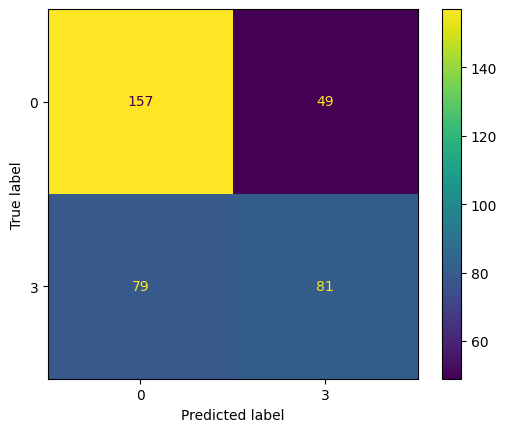

In [44]:
# Show image of confusion matrix

disp = ConfusionMatrixDisplay(confusion_matrix=CN_FIFS_cMatrix, display_labels=CN_FIFS_model.classes_)
disp.plot()
plt.show()

    Method 7: Modelling using feature selection based on feature importance values (with get_feature_importances type = "ShapValues"), with class imbalance accounted for

In [18]:
#SHAP explainer to explain CatBoost output
explainer = shap.TreeExplainer(CN_binary_model)

In [19]:
#SHAP values for X_train
CN_shap_values = explainer.shap_values(CP_NU_X_train)

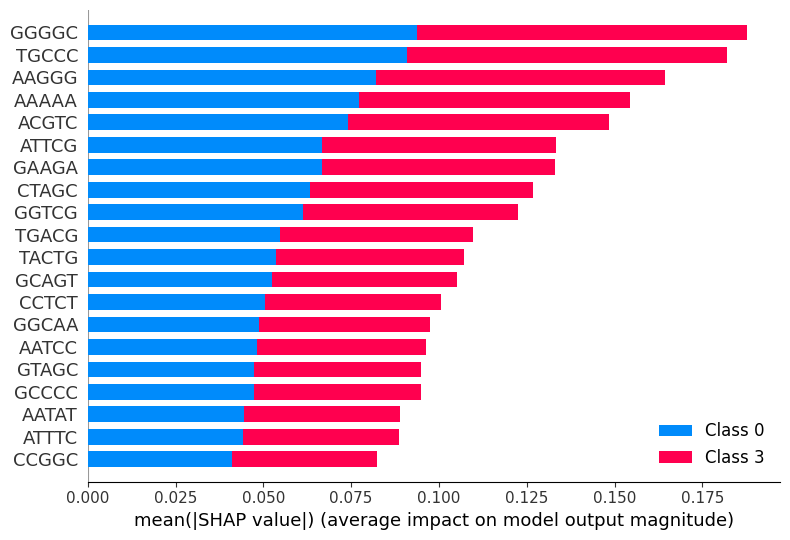

In [21]:
shap.summary_plot(CN_shap_values, CP_NU_X_train, plot_size=0.2, class_names=["Class 0", "Class 3"])

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


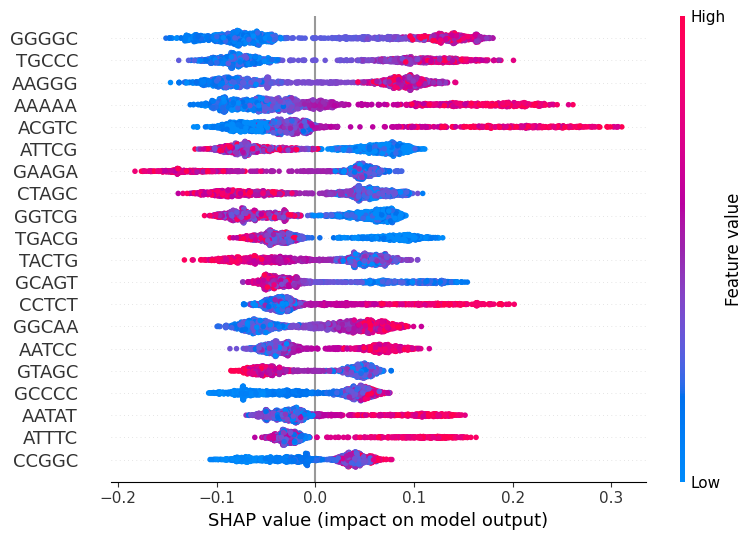

In [23]:
shap.summary_plot(CN_shap_values[0], CP_NU_X_train, plot_size=0.2)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


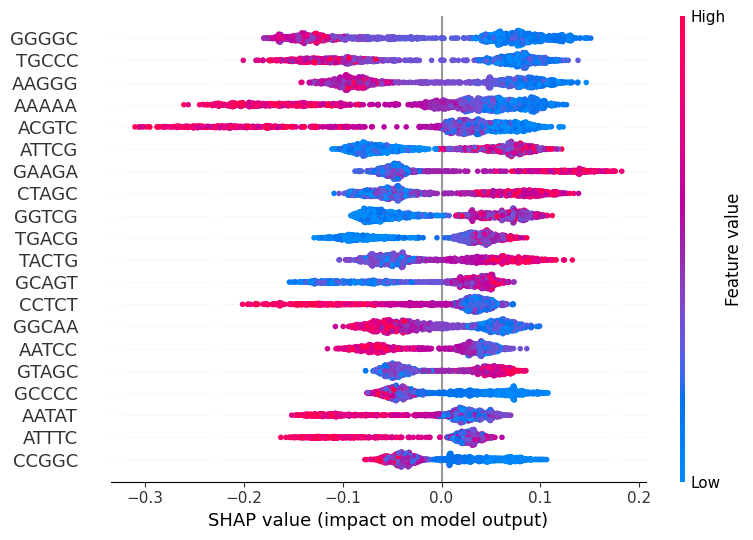

In [24]:
shap.summary_plot(CN_shap_values[1], CP_NU_X_train, plot_size=0.2)

In [25]:
shap_df = pd.DataFrame(CN_shap_values[0], columns=CP_NU_X_train.columns)


In [26]:
CN_shap_FI = (shap_df[shap_df>0]
                                .mean()
                                .sort_values(ascending=False)
                                .reset_index()
                                .rename(columns={'index':'Feature Id', 0:'Importances'})
                                # .head()
                        )

In [27]:
CN_shap_FI.head(100)

#### Check these feautre values with the features on shap plot for CP above #####
# Might need to use other method to get only features in with positive outcome + in red (those in red on right side):


,Feature Id,Importances
0,ACGTC,0.172806
1,AAAAA,0.121503
2,GGGGC,0.113204
3,CACTC,0.111559
4,TGCCC,0.107630
...,...,...
95,CCCCA,0.022110
96,TCAAA,0.021959
97,CTTAC,0.021372
98,ACGCA,0.021284


In [28]:
# shap.summary_plot(CN_shap_values[0], CP_NU_X_train, show=False, max_display=30, plot_size=0.2)

In [29]:
# #Try####

# vals= np.abs(CN_shap_values).mean(0)

# newtry_feature_importance = pd.DataFrame(list(zip(CP_NU_X_train.columns, sum(vals))), columns=['col_name','feature_importanCN_vals'])
# newtry_feature_importance.sort_values(by=['feature_importanCN_vals'], ascending=False,inplace=True)
# newtry_feature_importance

In [30]:
# newtry_feature_importance.head(10)

In [31]:
#Classifier results with CN_feature_importance

In [65]:
# Show only feature importances above threshold (based on shap plot)

CN_SHAP_thres_chosen = CN_shap_FI[CN_shap_FI['Importances'] >= 0.015]
CN_shap_num_chosen = len(CN_SHAP_thres_chosen)

print(CN_SHAP_thres_chosen)

print("\nAmount of features with importnace above 0.015 (selected features):", CN_shap_num_chosen)

    Feature Id  Importances
0        ACGTC     0.172806
1        AAAAA     0.121503
2        GGGGC     0.113204
3        CACTC     0.111559
4        TGCCC     0.107630
..         ...          ...
148      CGACA     0.015948
149      CCTGG     0.015917
150      AGAGT     0.015570
151      GCGCA     0.015548
152      ATAGA     0.015028

[153 rows x 2 columns]

Amount of features with importnace above 0.015 (selected features): 153


In [66]:
print("Sum of total feature importances: ", sum(CN_shap_FI.Importances))
print("Sum of feature importances >=0.015: ", sum(CN_SHAP_thres_chosen.Importances))

Sum of total feature importances:  nan
Sum of feature importances >=0.015:  5.293645546679071


In [67]:
# Select features with importance values above 0.1

CN_shap_selected_feat = CN_shap_FI[:CN_shap_num_chosen]['Feature Id'].tolist()

# print(CN_shap_selected_feat)

In [68]:
CP_NU_X_train.shape

(1464, 1024)

In [69]:
# See original training set

CP_NU_X_train.head(826)


,AAAAA,AAAAC,AAAAG,AAAAT,AAACA,AAACC,AAACG,AAACT,AAAGA,AAAGC,...,TTTCG,TTTCT,TTTGA,TTTGC,TTTGG,TTTGT,TTTTA,TTTTC,TTTTG,TTTTT
0,0.003643,0.000792,0.001426,0.002218,0.001584,0.000950,0.000792,0.000950,0.001901,0.001742,...,0.000000,0.002693,0.002059,0.001109,0.001109,0.002534,0.001584,0.001901,0.003168,0.003643
1,0.002914,0.000291,0.000583,0.000291,0.000583,0.000000,0.000000,0.000583,0.000874,0.001457,...,0.000583,0.000291,0.000583,0.000291,0.000000,0.001166,0.000291,0.001166,0.000583,0.000291
2,0.002291,0.001375,0.000458,0.001375,0.000000,0.000917,0.000458,0.001375,0.001375,0.000917,...,0.000917,0.001375,0.000917,0.000458,0.000458,0.000917,0.000917,0.002750,0.000458,0.000458
3,0.000000,0.000990,0.000495,0.000000,0.000990,0.000990,0.000000,0.000495,0.001484,0.000000,...,0.000000,0.000495,0.000990,0.000000,0.001484,0.000495,0.000495,0.000000,0.000000,0.000000
4,0.013061,0.002488,0.004043,0.004354,0.001451,0.001348,0.000415,0.002902,0.003110,0.001244,...,0.000311,0.001762,0.001970,0.000933,0.002591,0.001970,0.002695,0.002384,0.002488,0.003732
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
821,0.004328,0.002331,0.002331,0.002664,0.002997,0.000499,0.000000,0.001665,0.002331,0.002664,...,0.000000,0.002664,0.001998,0.001665,0.001332,0.003329,0.002331,0.001998,0.002664,0.003995
822,0.004830,0.001499,0.002498,0.004997,0.002332,0.001332,0.000333,0.000833,0.001832,0.001166,...,0.000000,0.002498,0.002831,0.001332,0.001832,0.003664,0.006329,0.002998,0.003831,0.008494
823,0.002500,0.000167,0.000500,0.000167,0.000500,0.000667,0.000167,0.000667,0.000667,0.000333,...,0.000167,0.000667,0.001167,0.000167,0.000333,0.000333,0.000333,0.000167,0.000167,0.000500
0,0.006391,0.001389,0.003334,0.001111,0.001389,0.000834,0.000556,0.000556,0.003056,0.000556,...,0.000000,0.000556,0.001389,0.000278,0.001389,0.001111,0.001111,0.000556,0.001945,0.005835


In [70]:
#Create training set with selected features 

CN_X_train_shap_selected = CP_NU_X_train[CN_shap_selected_feat]
CN_X_train_shap_selected.head()

,ACGTC,AAAAA,GGGGC,CACTC,TGCCC,ATTTC,TGAAT,GCAGT,AAGGG,CCTCT,...,GCTAC,ACATT,GAGTT,GAATA,CCTAT,CGACA,CCTGG,AGAGT,GCGCA,ATAGA
0,0.000317,0.003643,0.000475,0.001267,0.001267,0.002376,0.001109,0.000634,0.001267,0.000950,...,0.000792,0.000950,0.001267,0.000792,0.000158,0.000317,0.002059,0.001267,0.000792,0.001109
1,0.000000,0.002914,0.004371,0.000291,0.003497,0.000000,0.001166,0.000874,0.001748,0.003205,...,0.000583,0.000000,0.001166,0.000291,0.000291,0.000000,0.004953,0.001457,0.000583,0.000000
2,0.000000,0.002291,0.003208,0.000000,0.004125,0.001375,0.000917,0.000917,0.002750,0.002750,...,0.000458,0.000458,0.000917,0.000458,0.000000,0.000458,0.003208,0.002291,0.001375,0.000458
3,0.000000,0.000000,0.005938,0.001484,0.002969,0.000495,0.000000,0.002474,0.003464,0.001484,...,0.000495,0.000495,0.000990,0.000000,0.000495,0.000990,0.005443,0.000495,0.000990,0.000990
4,0.000207,0.013061,0.000207,0.000829,0.000726,0.001348,0.002591,0.001244,0.001037,0.000726,...,0.001140,0.001555,0.001451,0.001244,0.000518,0.000104,0.001140,0.001140,0.000104,0.001140


In [71]:
# Check whether columns in new training set are the same featues are the ones selected
if(list(CN_X_train_shap_selected.columns) == CN_shap_selected_feat):
    print("Selected and column features are the same; properly selected");
else:
    print("Features not selected properly")

Selected and column features are the same; properly selected


In [72]:
# Check whether number of variables/sequences of training set is the same as number of labels (no change should have been made to the sequences (rows), only to the features (columns)) 
print("Shape of X_train_selected (number of variables/sequences):", CN_X_train_shap_selected.shape)
print("Shape of y_train (number of labels):", CP_NU_y_train.shape)

Shape of X_train_selected (number of variables/sequences): (1464, 153)
Shape of y_train (number of labels): (1464,)


In [73]:
# Create pool object for selected feature data
print("Original number of features:", len(CN_feature_names), "\n Number of selected features:", len(CN_shap_selected_feat))

CN_shap_selected_train_pool = Pool(CN_X_train_shap_selected, CP_NU_y_train, feature_names=CN_shap_selected_feat)

Original number of features: 1024 
 Number of selected features: 153


In [74]:
#Create new model for data with selected features
CN_FIFS_shap_model = CatBoostClassifier(loss_function="MultiClass", auto_class_weights="Balanced")

# Fit new data into same model as before

CN_FIFS_shap_model.fit(CN_shap_selected_train_pool)

Learning rate set to 0.08068
0:	learn: 0.6800981	total: 35.9ms	remaining: 35.8s
1:	learn: 0.6665187	total: 59.8ms	remaining: 29.8s
2:	learn: 0.6527703	total: 82.1ms	remaining: 27.3s
3:	learn: 0.6376646	total: 104ms	remaining: 25.9s
4:	learn: 0.6277240	total: 125ms	remaining: 25s
5:	learn: 0.6188572	total: 147ms	remaining: 24.4s
6:	learn: 0.6058171	total: 168ms	remaining: 23.8s
7:	learn: 0.5958333	total: 189ms	remaining: 23.4s
8:	learn: 0.5880180	total: 211ms	remaining: 23.2s
9:	learn: 0.5796158	total: 233ms	remaining: 23.1s
10:	learn: 0.5715193	total: 258ms	remaining: 23.2s
11:	learn: 0.5644187	total: 280ms	remaining: 23s
12:	learn: 0.5550900	total: 299ms	remaining: 22.7s
13:	learn: 0.5473237	total: 319ms	remaining: 22.5s
14:	learn: 0.5379412	total: 340ms	remaining: 22.3s
15:	learn: 0.5300723	total: 360ms	remaining: 22.1s
16:	learn: 0.5214329	total: 380ms	remaining: 22s
17:	learn: 0.5152856	total: 400ms	remaining: 21.8s
18:	learn: 0.5100426	total: 421ms	remaining: 21.8s
19:	learn: 0.50

In [75]:
#Check parameters used in this model fit

CN_FIFS_shap_params = CN_FIFS_shap_model.get_all_params()
print("Basic model parameters:", CN_FIFS_shap_params)

Basic model parameters: {'nan_mode': 'Min', 'eval_metric': 'MultiClass', 'iterations': 1000, 'sampling_frequency': 'PerTree', 'leaf_estimation_method': 'Newton', 'grow_policy': 'SymmetricTree', 'penalties_coefficient': 1, 'boosting_type': 'Plain', 'model_shrink_mode': 'Constant', 'feature_border_type': 'GreedyLogSum', 'bayesian_matrix_reg': 0.10000000149011612, 'eval_fraction': 0, 'force_unit_auto_pair_weights': False, 'l2_leaf_reg': 3, 'random_strength': 1, 'rsm': 1, 'boost_from_average': False, 'model_size_reg': 0.5, 'pool_metainfo_options': {'tags': {}}, 'use_best_model': False, 'class_names': [0, 3], 'random_seed': 0, 'depth': 6, 'posterior_sampling': False, 'border_count': 254, 'class_weights': [1, 1.287500023841858], 'bagging_temperature': 1, 'classes_count': 0, 'auto_class_weights': 'Balanced', 'sparse_features_conflict_fraction': 0, 'leaf_estimation_backtracking': 'AnyImprovement', 'best_model_min_trees': 1, 'model_shrink_rate': 0, 'min_data_in_leaf': 1, 'loss_function': 'Multi

In [76]:
#Prediction using X_test only for selected features data
CN_FIFS_shap_y_pred = CN_FIFS_shap_model.predict(CP_NU_X_test)

#Predication probability for selected features data

CN_FIFS_shap_y_prob = CN_FIFS_shap_model.predict_proba(CP_NU_X_test)

In [77]:
# Calculate F1 score and get classification report

print("Model 7: Feature selection (SHAP) (model 3) w/ class imbalance accounted for - Cytoplasm & nucleus")

print("Number of chosen features:", len(CN_shap_selected_feat), "\n")

CN_FIFS_shap_cr = classification_report(CP_NU_y_test, CN_FIFS_shap_y_pred, digits=4)
print(CN_FIFS_shap_cr)

print('Accuracy score: ', accuracy_score(CP_NU_y_test, CN_FIFS_shap_y_pred))

CN_FIFS_shap_f1 = f1_score(CP_NU_y_test, CN_FIFS_shap_y_pred, average='macro')
print(f"\nF1 Score: {CN_FIFS_shap_f1}")
# print('Roc auc score : ', roc_auc_score(CP_NU_y_test, CN_FIFS_shap_y_prob))

Model 7: Feature selection (SHAP) (model 3) w/ class imbalance accounted for - Cytoplasm & nucleus
Number of chosen features: 153 

              precision    recall  f1-score   support

           0     0.6333    0.7379    0.6816       206
           3     0.5714    0.4500    0.5035       160

    accuracy                         0.6120       366
   macro avg     0.6024    0.5939    0.5926       366
weighted avg     0.6063    0.6120    0.6037       366

Accuracy score:  0.6120218579234973

F1 Score: 0.5925554266361441


In [78]:
# Confusion matrix for selected data

print("real values shape:", CP_NU_y_test.shape)
print("prediction shape:", CN_FIFS_shap_y_pred.shape)

CN_FIFS_shap_y_pred_fl = CN_FIFS_shap_y_pred
print("flattened prediction values shape:", CN_FIFS_shap_y_pred_fl.ravel().shape, "\n")

CN_FIFS_shap_cMatrix = confusion_matrix(CP_NU_y_test, CN_FIFS_shap_y_pred_fl)
print(CN_FIFS_shap_cMatrix)

real values shape: (366,)
prediction shape: (366, 1)
flattened prediction values shape: (366,) 

[[152  54]
 [ 88  72]]


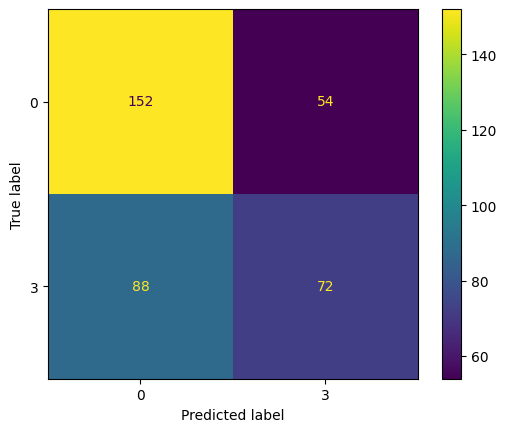

In [79]:
# Show image of confusion matrix

disp = ConfusionMatrixDisplay(confusion_matrix=CN_FIFS_shap_cMatrix, display_labels=CN_FIFS_shap_model.classes_)
disp.plot()
plt.show()

In [72]:
#Classifier results with newtry_feature_importance

In [73]:
newtry_feature_importance.head(500)

,col_name,feature_importanCN_vals
681,GGGGC,137.406248
917,TGCCC,133.247382
42,AAGGG,120.314131
0,AAAAA,113.029557
109,ACGTC,108.589419
...,...,...
77,ACATC,5.798831
10,AAAGG,5.797595
358,CCGCG,5.797354
808,TAGGA,5.793305


In [74]:
# Show only feature importances above 0.1

CN_newSHAP_thres_chosen = newtry_feature_importance[:300]
CN_newshap_num_chosen = len(CN_newSHAP_thres_chosen)

print(CN_newSHAP_thres_chosen)

print("\nAmount of features with importnace above 0.1 (selected features):", CN_newshap_num_chosen)

    col_name  feature_importanCN_vals
681    GGGGC               137.406248
917    TGCCC               133.247382
42     AAGGG               120.314131
0      AAAAA               113.029557
109    ACGTC               108.589419
..       ...                      ...
519    GAACT                 9.990864
46     AAGTG                 9.953755
856    TCCGA                 9.930188
866    TCGAG                 9.902032
628    GCTCA                 9.898274

[300 rows x 2 columns]

Amount of features with importnace above 0.1 (selected features): 300


In [75]:
print("Sum of total feature importances: ", sum(newtry_feature_importance.feature_importanCN_vals))
print("Sum of feature importances >=0.1: ", sum(CN_newSHAP_thres_chosen.feature_importanCN_vals))

Sum of total feature importances:  10853.119789594253
Sum of feature importances >=0.1:  7814.253937421171


In [76]:
# Select features with importance values above 0.1

CN_newshap_selected_feat = newtry_feature_importance[:CN_newshap_num_chosen]['col_name'].tolist()

print(CN_newshap_selected_feat)

['GGGGC', 'TGCCC', 'AAGGG', 'AAAAA', 'ACGTC', 'ATTCG', 'GAAGA', 'CTAGC', 'GGTCG', 'TGACG', 'TACTG', 'GCAGT', 'CCTCT', 'GGCAA', 'AATCC', 'GTAGC', 'GCCCC', 'AATAT', 'ATTTC', 'CCGGC', 'TCAAT', 'GGTGA', 'CTAGT', 'TGAAT', 'GTACG', 'ACCGA', 'CAGAT', 'CGGTA', 'ATCAC', 'CTCTA', 'CCCAA', 'GGGGA', 'GACGA', 'CACTC', 'AACGA', 'GTTAG', 'CATCT', 'GGGAT', 'GAAGT', 'TTGTC', 'CGTTG', 'GTTAC', 'TGAAG', 'AGGAA', 'TCGTA', 'CAGAC', 'CTCGC', 'CGAAA', 'CGAGT', 'TAAGG', 'ACGCA', 'GCCGT', 'GACAG', 'ACCCT', 'AGAAG', 'TTGCT', 'GCTCT', 'TAGCC', 'GCACA', 'GTCTG', 'TGTAC', 'ATGCG', 'CCCCA', 'TGGGG', 'GGATC', 'TAGGG', 'GTTTG', 'TGTCG', 'GTACC', 'TGAAC', 'GGCAG', 'CAATT', 'TTCAA', 'TTCGA', 'TGGCT', 'AGGGG', 'CGCAT', 'ATGCC', 'GTTCT', 'ACACG', 'CTGGG', 'GATAG', 'TCTCC', 'TAGAC', 'CTTAC', 'AGTCG', 'CCCTC', 'CTCGA', 'GGTAT', 'CAAGT', 'TCCCT', 'CTAAG', 'CGACA', 'AAAAG', 'CACCC', 'AGTTG', 'TCCGT', 'AGTTC', 'GGCGT', 'CCTAT', 'TGCTC', 'CTGCT', 'CCTGC', 'GTGTT', 'GAGTG', 'ACTCT', 'GTAGA', 'ATCTC', 'GTAGT', 'CTGTA', 'CGTCC', 

In [77]:
CP_NU_X_train.shape

(1464, 1024)

In [78]:
# See original training set

CP_NU_X_train.head(826)


,AAAAA,AAAAC,AAAAG,AAAAT,AAACA,AAACC,AAACG,AAACT,AAAGA,AAAGC,...,TTTCG,TTTCT,TTTGA,TTTGC,TTTGG,TTTGT,TTTTA,TTTTC,TTTTG,TTTTT
0,0.003643,0.000792,0.001426,0.002218,0.001584,0.000950,0.000792,0.000950,0.001901,0.001742,...,0.000000,0.002693,0.002059,0.001109,0.001109,0.002534,0.001584,0.001901,0.003168,0.003643
1,0.002914,0.000291,0.000583,0.000291,0.000583,0.000000,0.000000,0.000583,0.000874,0.001457,...,0.000583,0.000291,0.000583,0.000291,0.000000,0.001166,0.000291,0.001166,0.000583,0.000291
2,0.002291,0.001375,0.000458,0.001375,0.000000,0.000917,0.000458,0.001375,0.001375,0.000917,...,0.000917,0.001375,0.000917,0.000458,0.000458,0.000917,0.000917,0.002750,0.000458,0.000458
3,0.000000,0.000990,0.000495,0.000000,0.000990,0.000990,0.000000,0.000495,0.001484,0.000000,...,0.000000,0.000495,0.000990,0.000000,0.001484,0.000495,0.000495,0.000000,0.000000,0.000000
4,0.013061,0.002488,0.004043,0.004354,0.001451,0.001348,0.000415,0.002902,0.003110,0.001244,...,0.000311,0.001762,0.001970,0.000933,0.002591,0.001970,0.002695,0.002384,0.002488,0.003732
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
821,0.004328,0.002331,0.002331,0.002664,0.002997,0.000499,0.000000,0.001665,0.002331,0.002664,...,0.000000,0.002664,0.001998,0.001665,0.001332,0.003329,0.002331,0.001998,0.002664,0.003995
822,0.004830,0.001499,0.002498,0.004997,0.002332,0.001332,0.000333,0.000833,0.001832,0.001166,...,0.000000,0.002498,0.002831,0.001332,0.001832,0.003664,0.006329,0.002998,0.003831,0.008494
823,0.002500,0.000167,0.000500,0.000167,0.000500,0.000667,0.000167,0.000667,0.000667,0.000333,...,0.000167,0.000667,0.001167,0.000167,0.000333,0.000333,0.000333,0.000167,0.000167,0.000500
0,0.006391,0.001389,0.003334,0.001111,0.001389,0.000834,0.000556,0.000556,0.003056,0.000556,...,0.000000,0.000556,0.001389,0.000278,0.001389,0.001111,0.001111,0.000556,0.001945,0.005835


In [79]:
#Create training set with selected features 

CN_X_train_newshap_selected = CP_NU_X_train[CN_newshap_selected_feat]
CN_X_train_newshap_selected.head()

,GGGGC,TGCCC,AAGGG,AAAAA,ACGTC,ATTCG,GAAGA,CTAGC,GGTCG,TGACG,...,GAACC,CTACC,CCATG,AGCCG,CCCTA,GAACT,AAGTG,TCCGA,TCGAG,GCTCA
0,0.000475,0.001267,0.001267,0.003643,0.000317,0.000158,0.001584,0.000634,0.000158,0.000158,...,0.000634,0.001267,0.000475,0.000158,0.000475,0.000634,0.000792,0.000634,0.000158,0.000950
1,0.004371,0.003497,0.001748,0.002914,0.000000,0.000291,0.002040,0.000583,0.000291,0.000000,...,0.001748,0.001457,0.001748,0.001166,0.002040,0.000583,0.001457,0.000583,0.000291,0.001166
2,0.003208,0.004125,0.002750,0.002291,0.000000,0.000458,0.002291,0.000000,0.000000,0.000000,...,0.000917,0.000458,0.002291,0.001833,0.001375,0.000458,0.000458,0.000917,0.000917,0.000917
3,0.005938,0.002969,0.003464,0.000000,0.000000,0.000000,0.000000,0.000495,0.000990,0.000495,...,0.000000,0.001484,0.000000,0.000495,0.000495,0.000000,0.000990,0.000000,0.000990,0.001979
4,0.000207,0.000726,0.001037,0.013061,0.000207,0.000207,0.002281,0.000311,0.000104,0.000415,...,0.000829,0.001037,0.001348,0.000104,0.000207,0.001244,0.000829,0.000207,0.000311,0.001140


In [80]:
# Check whether columns in new training set are the same featues are the ones selected
if(list(CN_X_train_newshap_selected.columns) == CN_newshap_selected_feat):
    print("Selected and column features are the same; properly selected");
else:
    print("Features not selected properly")

Selected and column features are the same; properly selected


In [81]:
# Check whether number of variables/sequences of training set is the same as number of labels (no change should have been made to the sequences (rows), only to the features (columns)) 
print("Shape of X_train_selected (number of variables/sequences):", CN_X_train_newshap_selected.shape)
print("Shape of y_train (number of labels):", CP_NU_y_train.shape)

Shape of X_train_selected (number of variables/sequences): (1464, 300)
Shape of y_train (number of labels): (1464,)


In [82]:
# Create pool object for selected feature data
print("Original number of features:", len(CN_feature_names), "\n Number of selected features:", len(CN_newshap_selected_feat))

CN_newshap_selected_train_pool = Pool(CN_X_train_newshap_selected, CP_NU_y_train, feature_names=CN_newshap_selected_feat)

Original number of features: 1024 
 Number of selected features: 300


In [83]:
#Create new model for data with selected features
CN_FIFS_newshap_model = CatBoostClassifier(loss_function="MultiClass", auto_class_weights="Balanced")

# Fit new data into same model as before

CN_FIFS_newshap_model.fit(CN_newshap_selected_train_pool)

Learning rate set to 0.08068
0:	learn: 0.6789962	total: 43.8ms	remaining: 43.8s
1:	learn: 0.6659397	total: 79.5ms	remaining: 39.7s
2:	learn: 0.6549641	total: 120ms	remaining: 40s
3:	learn: 0.6445220	total: 154ms	remaining: 38.3s
4:	learn: 0.6330173	total: 189ms	remaining: 37.7s
5:	learn: 0.6242059	total: 225ms	remaining: 37.2s
6:	learn: 0.6165028	total: 262ms	remaining: 37.2s
7:	learn: 0.6076493	total: 304ms	remaining: 37.7s
8:	learn: 0.5982702	total: 339ms	remaining: 37.3s
9:	learn: 0.5895834	total: 373ms	remaining: 36.9s
10:	learn: 0.5810834	total: 408ms	remaining: 36.7s
11:	learn: 0.5728071	total: 449ms	remaining: 37s
12:	learn: 0.5661124	total: 487ms	remaining: 36.9s
13:	learn: 0.5593041	total: 522ms	remaining: 36.7s
14:	learn: 0.5530814	total: 559ms	remaining: 36.7s
15:	learn: 0.5475887	total: 593ms	remaining: 36.5s
16:	learn: 0.5413428	total: 636ms	remaining: 36.8s
17:	learn: 0.5353266	total: 681ms	remaining: 37.2s
18:	learn: 0.5276080	total: 722ms	remaining: 37.3s
19:	learn: 0.5

In [84]:
#Check parameters used in this model fit

CN_FIFS_newshap_params = CN_FIFS_newshap_model.get_all_params()
print("Basic model parameters:", CN_FIFS_newshap_params)

Basic model parameters: {'nan_mode': 'Min', 'eval_metric': 'MultiClass', 'iterations': 1000, 'sampling_frequency': 'PerTree', 'leaf_estimation_method': 'Newton', 'grow_policy': 'SymmetricTree', 'penalties_coefficient': 1, 'boosting_type': 'Plain', 'model_shrink_mode': 'Constant', 'feature_border_type': 'GreedyLogSum', 'bayesian_matrix_reg': 0.10000000149011612, 'eval_fraction': 0, 'force_unit_auto_pair_weights': False, 'l2_leaf_reg': 3, 'random_strength': 1, 'rsm': 1, 'boost_from_average': False, 'model_size_reg': 0.5, 'pool_metainfo_options': {'tags': {}}, 'use_best_model': False, 'class_names': [0, 3], 'random_seed': 0, 'depth': 6, 'posterior_sampling': False, 'border_count': 254, 'class_weights': [1, 1.287500023841858], 'bagging_temperature': 1, 'classes_count': 0, 'auto_class_weights': 'Balanced', 'sparse_features_conflict_fraction': 0, 'leaf_estimation_backtracking': 'AnyImprovement', 'best_model_min_trees': 1, 'model_shrink_rate': 0, 'min_data_in_leaf': 1, 'loss_function': 'Multi

In [85]:
#Prediction using X_test only for selected features data
CN_FIFS_newshap_y_pred = CN_FIFS_newshap_model.predict(CP_NU_X_test)

#Predication probability for selected features data

CN_FIFS_newshap_y_prob = CN_FIFS_newshap_model.predict_proba(CP_NU_X_test)

In [86]:
# Calculate F1 score and get classification report

CN_FIFS_newshap_f1 = f1_score(CP_NU_y_test, CN_FIFS_newshap_y_pred, average='macro')
print(f"F1 Score: {CN_FIFS_newshap_f1}")

CN_FIFS_newshap_cr = classification_report(CP_NU_y_test, CN_FIFS_newshap_y_pred, digits=4)
print(CN_FIFS_newshap_cr)

print('Accuracy score: ', accuracy_score(CP_NU_y_test, CN_FIFS_newshap_y_pred))
# print('Roc auc score : ', roc_auc_score(CP_NU_y_test, CN_FIFS_newshap_y_prob))

F1 Score: 0.5982940825990153
              precision    recall  f1-score   support

           0     0.6375    0.7427    0.6861       206
           3     0.5794    0.4562    0.5105       160

    accuracy                         0.6175       366
   macro avg     0.6084    0.5995    0.5983       366
weighted avg     0.6121    0.6175    0.6093       366

Accuracy score:  0.6174863387978142


In [87]:
# Confusion matrix for selected data

print("real values shape:", CP_NU_y_test.shape)
print("prediction shape:", CN_FIFS_newshap_y_pred.shape)

CN_FIFS_newshap_y_pred_fl = CN_FIFS_newshap_y_pred
print("flattened prediction values shape:", CN_FIFS_newshap_y_pred_fl.ravel().shape, "\n")

CN_FIFS_newshap_cMatrix = confusion_matrix(CP_NU_y_test, CN_FIFS_newshap_y_pred_fl)
print(CN_FIFS_newshap_cMatrix)

real values shape: (366,)
prediction shape: (366, 1)
flattened prediction values shape: (366,) 

[[153  53]
 [ 87  73]]


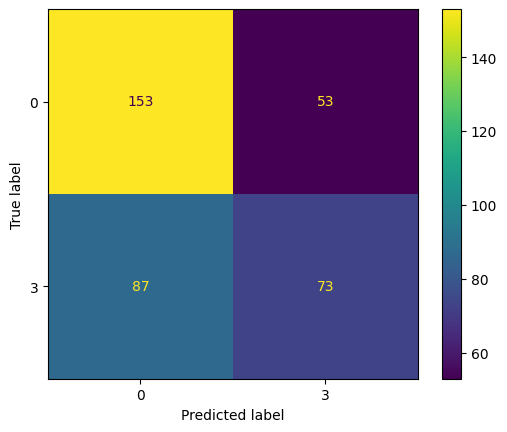

In [88]:
# Show image of confusion matrix

disp = ConfusionMatrixDisplay(confusion_matrix=CN_FIFS_newshap_cMatrix, display_labels=CN_FIFS_newshap_model.classes_)
disp.plot()
plt.show()